<a href="https://colab.research.google.com/github/ArthurMro/Prediction_marketing/blob/master/Prophet_GA_cs_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO TRY:


*   Combine data with Google trends
*   Clarify zone data, zone pred
*   Change shape point
*   X

Based on:
- GA extraction: https://www.youtube.com/watch?v=Xpx--7g6FKk
- Prophet: https://www.youtube.com/watch?v=95-HMzxsghY

In [11]:
from fbprophet import Prophet
import pandas as pd
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
from fbprophet.plot import add_changepoints_to_plot

In [12]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = 'ga-test-api-281612-230ee9ff6b34.json'
VIEW_ID = '193585107' #view cs.info

In [13]:
#Initializing report
def initialize_analyticsreporting():
  credentials = ServiceAccountCredentials.from_json_keyfile_name(
      KEY_FILE_LOCATION, SCOPES)
  analytics = build('analyticsreporting', 'v4', credentials=credentials)
  return analytics

In [14]:
#Get one report page
def get_report(analytics, pageTokenVar):
  return analytics.reports().batchGet(
      body={
        'reportRequests': [
        {
          'viewId': VIEW_ID,
          'dateRanges': [{'startDate': '600daysAgo', 'endDate': 'yesterday'}],
          'metrics': [{'expression': 'ga:sessions'}, {'expression': 'ga:Pageviews'}], #, {'expression': 'ga:Goal completions'} didn't work.
          'dimensions': [{'name': 'ga:Date'}],
          'pageSize': 10000,
          'pageToken': pageTokenVar,
          'samplingLevel': 'LARGE'
        }]
      }
  ).execute()

In [15]:
def handle_report(analytics,pagetoken,rows):  
    response = get_report(analytics, pagetoken)

    #Header, Dimensions Headers, Metric Headers 
    columnHeader = response.get("reports")[0].get('columnHeader', {})
    dimensionHeaders = columnHeader.get('dimensions', [])
    metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])

    #Pagination
    pagetoken = response.get("reports")[0].get('nextPageToken', None)
    
    #Rows
    rowsNew = response.get("reports")[0].get('data', {}).get('rows', [])
    rows = rows + rowsNew
    print("len(rows): " + str(len(rows)))

    #Recursivly query next page
    if pagetoken != None:
        return handle_report(analytics,pagetoken,rows)
    else:
        #nicer results
        nicerows=[]
        for row in rows:
            dic={}
            dimensions = row.get('dimensions', [])
            dateRangeValues = row.get('metrics', [])

            for header, dimension in zip(dimensionHeaders, dimensions):
                dic[header] = dimension

            for i, values in enumerate(dateRangeValues):
                for metric, value in zip(metricHeaders, values.get('values')):
                    if ',' in value or ',' in value:
                        dic[metric.get('name')] = float(value)
                    else:
                        dic[metric.get('name')] = int(value)
            nicerows.append(dic)
        return nicerows

In [16]:
#Start
def main():    
    analytics = initialize_analyticsreporting()
    
    global dfanalytics
    dfanalytics = []

    rows = []
    rows = handle_report(analytics,'0',rows)

    dfanalytics = pd.DataFrame(list(rows))


main()

print(dfanalytics)

len(rows): 499
      ga:Date  ga:sessions  ga:Pageviews
0    20190416            5             6
1    20190417            6            19
2    20190418            1             1
3    20190419           11            11
4    20190420            5             6
..        ...          ...           ...
494  20200926           31            71
495  20200927           34            76
496  20200928           38            54
497  20200929           21            51
498  20200930           24            42

[499 rows x 3 columns]


# 2. Prophet

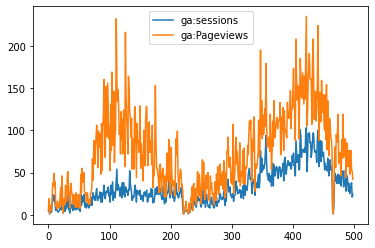

In [17]:
dfanalytics.plot()

## 2.1. Trial one: 300 days

The model seems to have not enough data to perform well when I take only 300 days. Let's see what we get for the trends and seasonality.

Still some conclusion regarding the week trend can be pulled out: Sunday and Monday are our best days. So if we want to even out, we could launch ads for Friday on so on.

## 2.2. Trial two: 600 days

###2.2.1 Train

#### 2.2.1.1 Creating dataset

In [45]:
df2 = dfanalytics

In [49]:
df2['ds'] = pd.to_datetime(df2['ga:Date'])
df2.rename(columns={'ga:sessions': 'y'}, inplace= True)
df2.drop(['ga:Date', 'ga:Pageviews'], axis=1, inplace=True)

print(df2.head())

KeyError: ignored

#### 2.2.1.2 Removing outliers

From the 27th to the 30th of August included, the data was skewed by a website crash. We will thus replace these values by value in the range of the values around: between 54 and 40, gradually decreasing.

In [20]:
df2.loc[df2.ds == '2020-08-27 00:00:00', 'y'] = 43
df2.loc[df2.ds == '2020-08-28 00:00:00', 'y'] = 40
df2.loc[df2.ds == '2020-08-29 00:00:00', 'y'] = 44
df2.loc[df2.ds == '2020-08-30 00:00:00', 'y'] = 44

In [21]:
df2.tail(30)

,y,ds
469,49,2020-09-01
470,40,2020-09-02
471,46,2020-09-03
472,37,2020-09-04
473,44,2020-09-05
474,48,2020-09-06
475,38,2020-09-07
476,37,2020-09-08
477,47,2020-09-09
478,42,2020-09-10


Second part needs to defer the crash that I got between the 23rd of November and the 28th of December. For that I'll grab back the data from the Google Trends and input a base visitors numbers of 20.

We'll play wild. I took the Google Trends number, clicked the first number of the trends with the last one I had, added a 10 base fix and then sumplemented the soup by adding a random (-3, 3) 

Here is the results: 
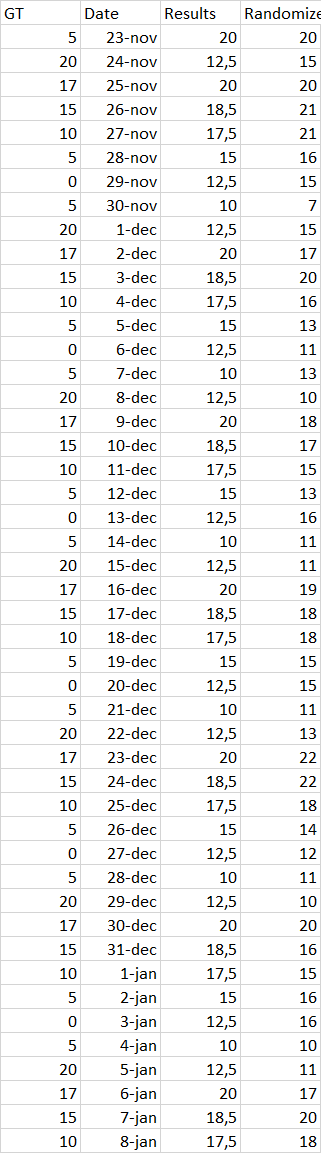


Ok it didn't work by just tranforming the y of certain data, as these dates don't exist. I have to first add some the missing dates to the df.

In [22]:
df2.ds.head()

0   2019-04-16
1   2019-04-17
2   2019-04-18
3   2019-04-19
4   2019-04-20
Name: ds, dtype: datetime64[ns]

In [23]:
missing_dates = pd.date_range(start = '2019-04-16', end = '2019-12-29' ).difference(df2['ds'])
print(missing_dates)

DatetimeIndex(['2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-30', '2019-12-01',
               '2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05',
               '2019-12-06', '2019-12-07', '2019-12-08', '2019-12-09',
               '2019-12-10', '2019-12-11', '2019-12-12', '2019-12-13',
               '2019-12-14', '2019-12-15', '2019-12-16', '2019-12-17',
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-21',
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27'],
              dtype='datetime64[ns]', freq=None)


In [24]:
df_missing_dates = pd.DataFrame(missing_dates)
df_missing_dates.columns = ['ds']
list_replace_values = [20, 15, 20, 21, 21, 16, 7, 15, 17, 20, 16, 13, 11, 13, 10, 18, 17, 15, 13, 16, 11, 11, 19, 18, 18, 15, 15, 22, 21, 11, 13, 9, 7, 4]
df_missing_dates['y'] = list_replace_values

Now I will have to concat and then sort to have a nice df2.

In [25]:
df2 = pd.concat([df2, df_missing_dates])
df2['cap'] = 120
df2['floor'] = 0

In [26]:
df2.sort_values('ds', inplace=True)

Now let's implement this change. Edit: doing it 'by hand' doesn't work. I remove the section.

Second try: didn't work. Seems that we have a problem of data types

In [27]:
df2.reset_index(inplace=True)

In [28]:
df2[200:240]

,index,y,ds,cap,floor
200,200,24,2019-11-02,120,0
201,201,37,2019-11-03,120,0
202,202,27,2019-11-04,120,0
203,203,25,2019-11-05,120,0
204,204,20,2019-11-06,120,0
205,205,28,2019-11-07,120,0
206,206,16,2019-11-08,120,0
207,207,19,2019-11-09,120,0
208,208,35,2019-11-10,120,0
209,209,37,2019-11-11,120,0


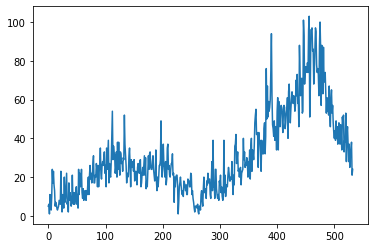

In [29]:
df2['y'].plot()

####2.2.1.3 Tweaking the model

Now while creating the model, we'll tweak some default paramters. Indeed the previous model was clearly underfitting.


*   We'll add seasonality_mode='multiplicative' as parameters, because the seasonality grows in influence
*   changepoint_prior_scale=0.5 to cope with the underfitting. Increasing makes the trends more flexible (so visually broadening the end funnel)
*   A cap of 50k and a floor of 0 in the dataset (just above)
*   yearly.seasonality = 20. It was 10 but I want more


*   List item





In [30]:
model = Prophet(changepoint_prior_scale=0.5, changepoint_range=0.9, seasonality_mode='multiplicative', yearly_seasonality = 10)
model.fit(df2)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
#Forecasting
future = model.make_future_dataframe(periods= 60)
future['cap'] = 120
future['floor'] = 0
print(future.tail())

            ds  cap  floor
588 2020-11-25  120      0
589 2020-11-26  120      0
590 2020-11-27  120      0
591 2020-11-28  120      0
592 2020-11-29  120      0


In [32]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
588,2020-11-25,18.890158,120,0.964035,19.928888,17.481641,20.231399,-0.443103,-0.443103,-0.443103,-0.011695,-0.011695,-0.011695,-0.431408,-0.431408,-0.431408,0.0,0.0,0.0,10.519868
589,2020-11-26,18.708023,120,0.409417,20.205224,17.251241,20.078153,-0.484912,-0.484912,-0.484912,-0.038008,-0.038008,-0.038008,-0.446904,-0.446904,-0.446904,0.0,0.0,0.0,9.636277
590,2020-11-27,18.525888,120,-1.539910,17.068264,17.030054,19.918183,-0.578625,-0.578625,-0.578625,-0.119013,-0.119013,-0.119013,-0.459613,-0.459613,-0.459613,0.0,0.0,0.0,7.806344
591,2020-11-28,18.343753,120,-1.071946,17.648403,16.788336,19.792350,-0.529139,-0.529139,-0.529139,-0.059546,-0.059546,-0.059546,-0.469593,-0.469593,-0.469593,0.0,0.0,0.0,8.637366
592,2020-11-29,18.161618,120,0.654187,21.746483,16.553642,19.653805,-0.369183,-0.369183,-0.369183,0.107793,0.107793,0.107793,-0.476975,-0.476975,-0.476975,0.0,0.0,0.0,11.456665


In [33]:
forecast.columns

Index(['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'yhat'],
      dtype='object')

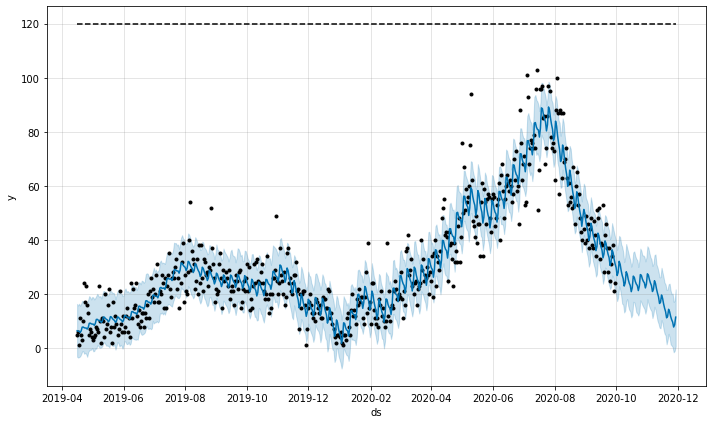

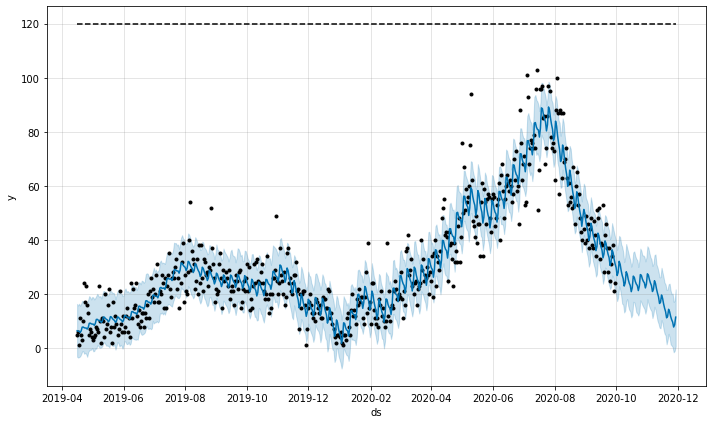

In [34]:
model.plot(forecast)

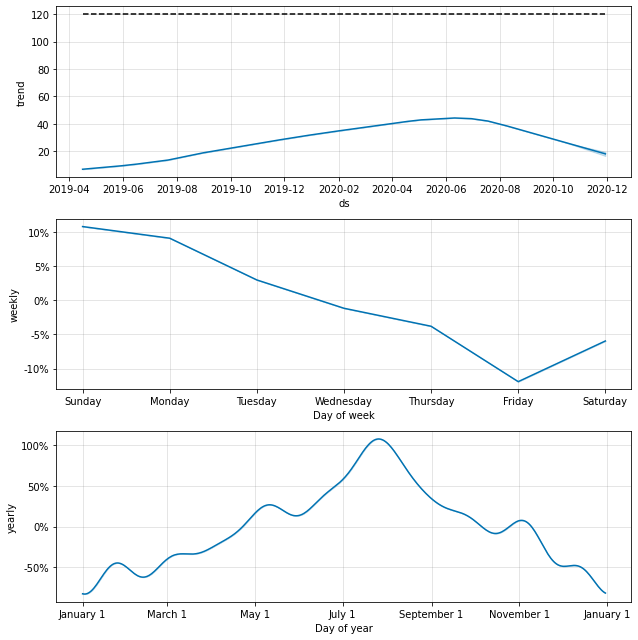

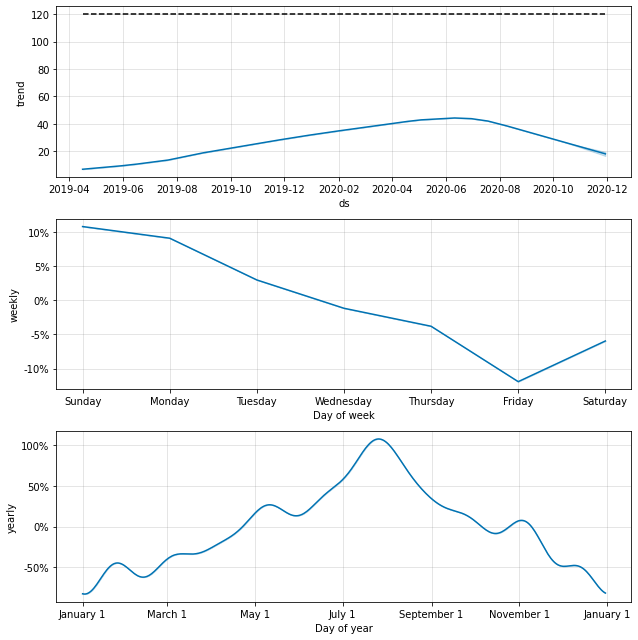

In [35]:
model.plot_components(forecast)

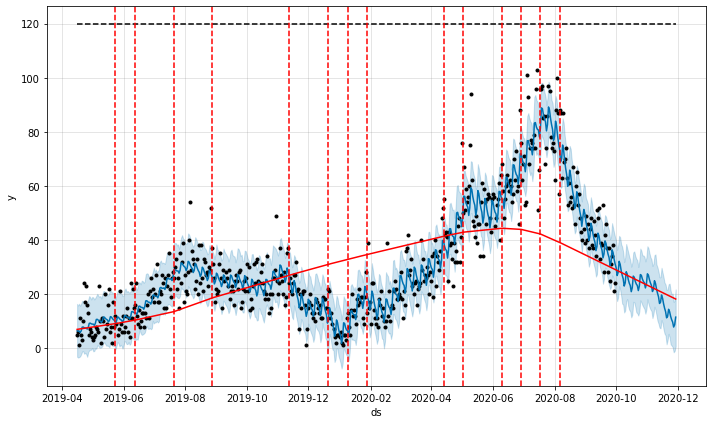

In [36]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

### 2.2.2 Test

In [37]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '30 days', parallel="processes")
df_cv.head()

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-04-18 00:00:00 and 2020-08-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa75bc50908>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-04-19,45.002833,37.107311,52.498722,38,2020-04-18
1,2020-04-20,48.217092,40.334380,55.518309,39,2020-04-18
2,2020-04-21,47.593368,39.966076,55.643259,33,2020-04-18
3,2020-04-22,44.428043,36.853198,52.134629,23,2020-04-18
4,2020-04-23,44.186910,36.470090,51.429532,39,2020-04-18


In [38]:
# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(20)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,134.985378,11.618321,10.125695,0.179709,0.184473,0.434483
1,4 days,140.138759,11.838022,10.092622,0.191327,0.167763,0.434483
2,5 days,136.243146,11.672324,9.913825,0.189129,0.152623,0.500000
3,6 days,148.044039,12.167335,9.903286,0.196412,0.156729,0.537931
4,7 days,120.346099,10.970237,8.719584,0.155294,0.132998,0.668966
5,8 days,122.090680,11.049465,8.602431,0.157800,0.121528,0.668966
6,9 days,160.140760,12.654673,9.613958,0.173092,0.119583,0.627586
7,10 days,255.457211,15.983029,12.583501,0.239703,0.121714,0.462069
8,11 days,345.609953,18.590588,15.126928,0.296679,0.263190,0.362069
9,12 days,351.218793,18.740832,15.607622,0.307592,0.283048,0.300000


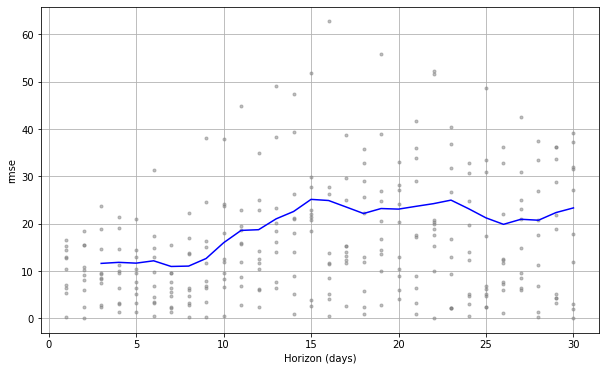

In [39]:
# Visualizing the performance metrics
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

Final step: savign the forecast as txt. That's for the sake of the visualization.

In [40]:
forecast[['ds', 'yhat']].to_csv('forecast.txt',index=False, header=False)

#3. Animation

It's time to make a funny graphical animation of the plot.
I followed the tutorial here: https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c
https://www.youtube.com/watch?v=ZmYPzESC5YY
https://medium.com/datadriveninvestor/time-series-animation-in-matplotlib-de023655a197

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib import style
from datetime import datetime
from matplotlib.animation import FuncAnimation
%matplotlib inline

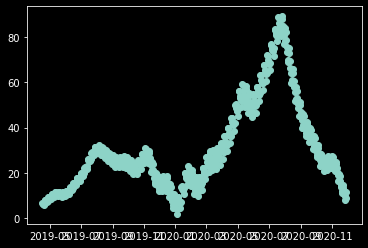

In [42]:
with plt.style.context('dark_background'):
    plt.subplot(1,1,1)
    plt.plot(forecast['ds'], forecast['yhat'], linestyle="",marker="o")

In [43]:
forecast.head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-04-16,6.938275,120,-3.216551,16.367704,6.938275,6.938275,-0.075406,-0.075406,-0.075406,0.029710,0.029710,0.029710,-0.105116,-0.105116,-0.105116,0.0,0.0,0.0,6.415086
1,2019-04-17,6.993802,120,-3.498253,15.754073,6.993802,6.993802,-0.104035,-0.104035,-0.104035,-0.011695,-0.011695,-0.011695,-0.092340,-0.092340,-0.092340,0.0,0.0,0.0,6.266199
2,2019-04-18,7.049330,120,-3.316789,16.451345,7.049330,7.049330,-0.116835,-0.116835,-0.116835,-0.038008,-0.038008,-0.038008,-0.078827,-0.078827,-0.078827,0.0,0.0,0.0,6.225721
3,2019-04-19,7.104857,120,-3.035380,15.608240,7.104857,7.104857,-0.183534,-0.183534,-0.183534,-0.119013,-0.119013,-0.119013,-0.064521,-0.064521,-0.064521,0.0,0.0,0.0,5.800876
4,2019-04-20,7.160385,120,-2.254111,16.421448,7.160385,7.160385,-0.108934,-0.108934,-0.108934,-0.059546,-0.059546,-0.059546,-0.049388,-0.049388,-0.049388,0.0,0.0,0.0,6.380378


##3.1 Creating the frame

In [51]:
df3 = forecast.merge(df2, on='ds', how = 'left')

In [53]:
df3.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
588,2020-11-25,18.890158,120,0.964035,19.928888,17.481641,20.231399,-0.443103,-0.443103,-0.443103,-0.011695,-0.011695,-0.011695,-0.431408,-0.431408,-0.431408,0.0,0.0,0.0,10.519868,NaN
589,2020-11-26,18.708023,120,0.409417,20.205224,17.251241,20.078153,-0.484912,-0.484912,-0.484912,-0.038008,-0.038008,-0.038008,-0.446904,-0.446904,-0.446904,0.0,0.0,0.0,9.636277,NaN
590,2020-11-27,18.525888,120,-1.539910,17.068264,17.030054,19.918183,-0.578625,-0.578625,-0.578625,-0.119013,-0.119013,-0.119013,-0.459613,-0.459613,-0.459613,0.0,0.0,0.0,7.806344,NaN
591,2020-11-28,18.343753,120,-1.071946,17.648403,16.788336,19.792350,-0.529139,-0.529139,-0.529139,-0.059546,-0.059546,-0.059546,-0.469593,-0.469593,-0.469593,0.0,0.0,0.0,8.637366,NaN
592,2020-11-29,18.161618,120,0.654187,21.746483,16.553642,19.653805,-0.369183,-0.369183,-0.369183,0.107793,0.107793,0.107793,-0.476975,-0.476975,-0.476975,0.0,0.0,0.0,11.456665,NaN


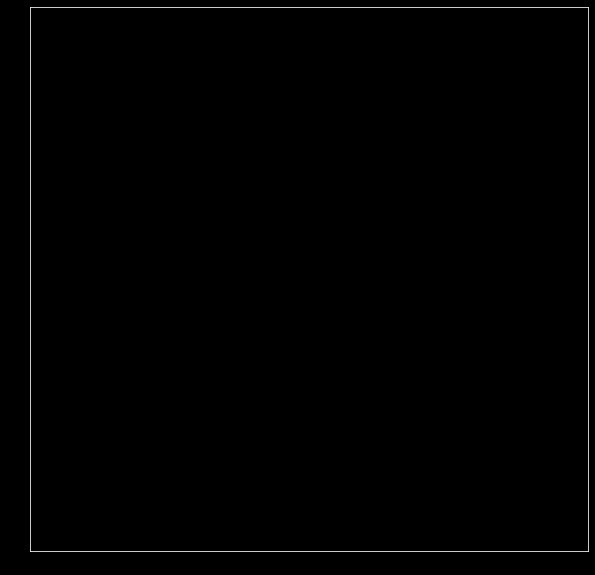

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 720x720 -pix_fmt rgba -r 15 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -b 1800k -metadata artist=Arthur_Moreau -y animation_video.mp4


In [55]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(10,10))
    #creating a subplot 
    ax1 = fig.add_subplot(1,1,1)

ax1.axis(xmin= (df3['ds'].min()), xmax=(df3['ds'].max()))
ax1.axis(ymin= (df3['yhat'].min()), ymax=(df3['yhat'].max()))


def animate(i):
#   set the variable data to contain 0 to the (i+1)th row:
    lines =  df3.iloc[:int(i+1)] 
    xs = []
    ys = []
    zs = []
    for line in lines:
        if len(line)>1:
            xs = lines['ds']
            ys = lines['yhat']
            zs = lines['y']
    ax1.clear()
    ax1.plot(xs, ys)
    ax1.plot(xs, zs)

ani = animation.FuncAnimation(fig, animate, frames = len(forecast), interval=10) 

plt.show()


Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Arthur_Moreau'), bitrate=1800)
ani.save('animation_video.mp4', writer=writer)